<a href="https://colab.research.google.com/github/hyunj941031/ds-sa-cp2/blob/main/models/BERT4Rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install python-box

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# 1. 학습 parameter 설정

In [ ]:
config = {
    'data_path' : '/content/drive/MyDrive/fashion_campus_dataset',
    
    'sequence_len' : 50,
    'mask_prob' : 0.3, # cloze task
    'random_seed' : 123,

    'num_layers' : 2, # block 수 (encoder layer 수)
    'hidden_units' : 50, # Embedding size
    'num_heads' : 2, # Multi-head layer 수 (병렬처리), hidden_units를 나눴을 때 나누어 떨어지게게
    'dropout' : 0.15, # dropout의 비율

    'epoch' : 5,
    'patience' : 5,
    'batch_size' : 256,
    'lr' : 0.001,

    'num_epochs' : 10,
    'num_workers' : 4,
    'val_data' : 3,
    'delete_data' : True,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 2. 데이터 전처리

In [ ]:
class MakeSequenceDataSet():
    """
    SequenceData 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'user_item.csv'), index_col=0)
        if config['delete_data']:
            self.df = self.delete_ones()

        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('itemId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_items, self.num_users = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['itemId'].apply(lambda x : self.item_encoder[x] + 1)
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])
        self.df = self.df.sort_values(['user_idx', 'timestamp']) # 시간에 따른 정렬
        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col:str) -> dict:
        '''
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Return:
            dict: 생성된 user encoder, decoder
        '''

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id
        
        return encoder, decoder

    def delete_ones(self) -> dict:
        a = self.df.groupby('userId')['itemId'].size()
        for i in a.index:
            if a[i] <= config['val_data']:
                del(a[i])
        df_ = self.df.copy()
        df_ = df_[df_['userId'].isin(a.index)]
                
        return df_

    def generate_sequence_data(self) -> dict:
        '''
        sequence data 생성

        Return:
            dict: train user sequence / valid user sequence
        '''
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())

        for user in users:
            user_train[user] = users[user][:-config['val_data']]
            user_valid[user] = users[user][-config['val_data']:] # 마지막 아이템 예측

        return user_train, user_valid

    def get_train_valid_data(self):
        return self.user_train, self.user_valid

In [ ]:
class BERTTrainDataSet(Dataset):
    def __init__(self, user_train, num_users, num_items, sequence_len=200, mask_prob=0.15, random_seed=None):
        self.user_train = user_train
        self.num_users = num_users
        self.num_items = num_items
        self.sequence_len = sequence_len
        self.mask_prob = mask_prob
        self._all_items = set([i for i in range(1, self.num_items + 1)])

        # rng
        if random_seed is None:
            self.rng = random.Random()
        else:
            self.rng = random.Random(random_seed)

        # tokens
        self.mask_token = self.num_items + 1


    def __len__(self):
        # 총 user 수(학습에 사용할 sequence 수수)
        return self.num_users

    def __getitem__(self, user):
        seq = self.user_train[user]
        tokens = []
        labels = []
        for s in seq[-self.sequence_len:]:
            prob = np.random.random()
            if prob < self.mask_prob:
                prob /= self.mask_prob
                # BERT 학습
                # random 하게 80% 를 mask token 으로 변환
                if prob < 0.8:
                    # masking
                    # mask_index : num_item + 1 , 0 : pad, 1 ~ num_item : item index
                    tokens.append(self.mask_token)
                elif prob < 0.9:
                    # item random sampling (noise)
                    tokens.append(np.random.randint(1, self.num_items))
                else:
                    # 나머지 10% 를 original token 으로 사용
                    tokens.append(s)
                labels.append(s) # 학습에 사용
            # training 에 사용하지 않음 
            else:
                tokens.append(s)
                labels.append(0) # 학습에 사용하지 않음, trivial

        # zero padding 
        # tokens 와 labels 가 padding_len 보다 짧으면 zero padding 을 해준다. 
        padding_len = self.sequence_len - len(tokens)
        
        tokens = [0] * padding_len + tokens
        labels = [0] * padding_len + labels
        return torch.LongTensor(tokens), torch.LongTensor(labels)

    def _getseq(self, user):
        return self.user_train[user]

    def random_neg_sampling(self, sold_items, num_item_sample):
        nge_samples = random.sample(list(self._all_items - set(sold_items)), num_item_sample)
        return nge_samples

class BertEvalDataset(Dataset):
    def __init__(self, u2seq, u2answer, sequence_len, mask_token, negative_samples):
        self.u2seq = u2seq
        self.users = sorted(self.u2seq.keys())
        self.u2answer = u2answer
        self.sequence_len = sequence_len
        self.mask_token = mask_token
        self.negative_samples = negative_samples

    def __len__(self):
        return len(self.users)

    def __getitem__(self, index):
        user = self.users[index]
        seq = self.u2seq[user]
        answer = self.u2answer[user]
        negs = self.random_neg_sampling(sold_item=user, num_item_sample = 1)

        candidates = answer + negs
        labels = [1] * len(answer) + [0] * len(negs)

        seq = seq + [self.mask_token]
        seq = seq[-self.sequence_len:]
        padding_len = self.sequence_len - len(seq)
        seq = [0] * padding_len + seq

        return torch.LongTensor(seq), torch.LongTensor(candidates), torch.LongTensor(labels)
    
    def random_neg_sampling(self, sold_items, num_item_sample : int):
        nge_samples = random.sample(list(self._all_items - set(sold_items)), num_item_sample)
        return nge_samples

# 3. 모델

### Util

In [ ]:
def fix_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

In [ ]:
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.alpha * (x - mean) / (std + self.eps) + self.beta

In [ ]:
class SublayerConnection(nn.Module):
    # layer가 많아지면 학습이 잘 안되는 현상
    # 따라서, sub-layer들에 각각 dropout을 한 후 서로 residual connection을 적용하고, layer normalization 적용
    def __init__(self, hidden_units, dropout):
        super().__init__()
        self.hidden_units = hidden_units
        self.dropout = dropout

        self.norm = LayerNorm(hidden_units)
        self.dropout = nn.Dropout(dropout)

    def forward(self, sublayer, x):
        "Apply residual connection to any sublayer with the same size."
        r = self.norm(x)
        r = sublayer(r)

        r = self.dropout(r)

        return x + r

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, d_ff, dropout=0.1):
        super().__init__()

        self.w_1 = nn.Linear(hidden_units, d_ff)
        self.w_2 = nn.Linear(d_ff, hidden_units)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))

## Attention

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super().__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate) # dropout rate

    def forward(self, Q, K, V, mask=None, dropout=None):
        """
            b = batch, ? = num_heads, L = sequence_len

            Q: (b x ? x L x dim_Q)
            K: (b x ? x L x dim_K)
            V: (b x ? x L x dim_V)
            ?: 1 (squeezed) or h (multi-head)
            mask: (b x ? x L x L)
            dropout: nn.Module
            assuming dim_Q = dim_K
        """

        # A: (b x ? x L x L)
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units)

        # apply mask (the logit value of a padding token should be minus infinity)
        if mask is not None:
            attn_score = attn_score.masked_fill(mask == 0, -1e9) # 유사도가 0인 지점은 -infinity로 보내서 softmax 결과가 0이 아니게 함
        
        # getting normalized(probability) weights through softmax (when padding token, it'll be 0)
        # P: (b x ? x L x L)
        p_attn = F.softmax(attn_score, dim=-1)
        
        # apply dropout (with given dropout)
        if dropout is not None:
            p_attn = self.dropout(p_attn) # attention distribution 상대적 중요도

        # (b x ? x L x L) @ (b x ? x L x dim_V) -> (b x ? x L x dim_V)
        output = torch.matmul(p_attn, V)

        return output, p_attn

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout=0.1):

        """
            dim_V should be equal to hidden_units / num_heads
            we assume dim_Q = dim_K = dim_V
        """

        super().__init__()
        assert hidden_units % num_heads == 0

        self.hidden_units = hidden_units
        self.num_heads = num_heads

        self.dim_V = hidden_units // num_heads

        # query, key, value, output 생성을 위한 Linear 모델 생성
        self.W_Q = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)

        self.W_O = nn.Linear(hidden_units * num_heads, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout)
        self.dropout = nn.Dropout(p=dropout)
        self.layerNorm = LayerNorm(hidden_units)

    def forward(self, enc, mask):

        residual = enc

        batch_size, seqlen = enc.size(0), enc.size(1)

        # 1) Do all the linear projections in a batch from dim_model, then split into (num_heads x dim_V)
        # [process]
        # (1) linear(W): (b x L x dim_model) -> (b x L x dim_model)
        # (2) view: (b x L x dim_model) -> (b x L x num_heads x dim_V)
        # (3) transpose: (b x L x num_heads x dim_V) -> (b x num_heads x L x dim_V)
        # Query, Key, Value를 (num_head)개의 Head로 나누어 각기 다른 Linear projection을 통과시킴
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units).transpose(1, 2)
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units).transpose(1, 2)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units).transpose(1, 2)

        # 2) Apply attention to the projected vectors in the batch
        # note that attenion only cares about the last two dimensions
        # output: (b x num_heads x L x dim_V)
        # Head별로 각기 다른 attention이 가능하도록 각각 attention에 통과시킴
        output, attn_dist = self.attention(Q, K, V, mask=mask, dropout=self.dropout) # attn_dist : (batch_size, num_heads, sequence_len, sequence_len)

        # 3) "concat" those heads using view
        # [process]
        # (1) transpose: (b x num_heads x L x dim_V) -> (b x L x num_heads x dim_V)
        # (2) contiguous: reorder memory inside GPU (no dimension change)
        # (3) view: (b x L x num_heads x dim_V) -> (b x L x dim_model)
        # 다시 Transpose한 후 모든 head들의 attention 결과를 합칩니다.
        output = output.transpose(1, 2).contiguous() # (batch_size, sequence_len, num_heads, d_model) / contiguous() : 가변적 메모리 할당
        output = output.view(batch_size, seqlen, -1) # (batch_size, sequence_len, d_model * num_heads)

        # 4) apply the final linear
        # X: (b x L x dim_model)
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual)

        return output

## Model

In [ ]:
class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden_units=256, num_heads=4, d_ff=1024, dropout=0.1):
        """
        :param hidden_units: hidden_units size of transformer
        :param num_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_units
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, hidden_units=hidden_units, dropout=dropout)
        self.attention_sublayer = SublayerConnection(hidden_units=hidden_units, dropout=dropout)
        self.pwff = PositionwiseFeedForward(hidden_units=hidden_units, d_ff=d_ff, dropout=dropout)
        self.pwff_sublayer = SublayerConnection(hidden_units=hidden_units, dropout=dropout)
        self.dropoutlayer = nn.Dropout(p=dropout)

    def forward(self, input_enc, mask=None):
        # we need dynamic mask for the attention forward (sublayer module also has parameters, namely layernorm)
        # x: (b x L x dim_model)
        # mask: (b x L x L), set False to ignore that point
        x = self.attention_sublayer(lambda _x: self.attention(_x, mask=mask), input_enc)
        x = self.pwff_sublayer(self.pwff, x)
        return self.dropoutlayer(x)

class BERT4Rec(nn.Module):
    def __init__(self, num_users, num_items, sequence_len, device, num_layers=2, hidden_units=256, num_heads=4, dropout=0.1, random_seed=None):
        super().__init__()

        # params
        self.num_users = num_users
        self.num_items = num_items
        self.sequence_len = sequence_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.num_heads = num_heads
        self.dropout = dropout
        self.random_seed = random_seed
        self.device = device
        
        # set seed
        if random_seed is not None:
            fix_random_seed(random_seed)

        # 0: padding token
        # 1 ~ V: item tokens
        # V + 1: mask token

        # Embedding layers
        self.item_emb = nn.Embedding(num_items + 2, hidden_units, padding_idx=0) # padding : 0 / item : 1 ~ num_item + 1 /  mask : num_item + 2
        self.pos_emb = nn.Embedding(sequence_len, hidden_units) # learnable positional encoding
        self.dropout = nn.Dropout(dropout)
        self.emb_layernorm = nn.LayerNorm(hidden_units, eps=1e-6)

        # transformer layers
        self.transformers = nn.ModuleList([
            TransformerBlock(
                hidden_units=hidden_units,
                num_heads=num_heads,
                d_ff=hidden_units*4,
                dropout=dropout
            ) for _ in range(num_layers)
        ])
        self.out = nn.Linear(hidden_units, num_items + 1)
    
    def forward(self, tokens):
        L = tokens.shape[1]

        # mask for whether padding token or not in attention matrix (True if padding token)
        # [process] (b x L) -> (b x 1 x L) -> (b x L x L) -> (b x 1 x L x L)
        token_mask = torch.BoolTensor(tokens > 0).unsqueeze(1).repeat(1, L, 1).unsqueeze(1).to(self.device)

        # get embedding
        # [process] (b x L) -> (b x L x d)
        seqs = self.item_emb(torch.LongTensor(tokens).to(self.device))  # (batch_size, sequence_len, hidden_units)
        positions = np.tile(np.array(range(tokens.shape[1])), [tokens.shape[0], 1])  # (batch_size, sequence_len)
        seqs += self.pos_emb(torch.LongTensor(positions).to(self.device))  # (batch_size, sequence_len, hidden_units)
        seqs = self.emb_layernorm(self.dropout(seqs))  # LayerNorm

        # apply multi-layered transformers
        # [process] (b x L x d) -> ... -> (b x L x d)
        for transformer in self.transformers:
            seqs = transformer(seqs, token_mask)

        # classifier
        # [process] (b x L x d) -> (b x L x (V + 1))
        out = self.out(seqs)

        return out

# 4. 학습함수

In [ ]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    loss_val = 0
    for seq, labels in data_loader:
        logits = model(seq)  # B x T x V

        logits = logits.view(-1, logits.size(-1))  # (B*T) x V
        labels = labels.view(-1).to(device)  # B*T

        optimizer.zero_grad()
        loss = criterion(logits, labels)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()
    
    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, user_train, user_valid, sequence_len, bert4rec_dataset, make_sequence_dataset):
    model.eval()

    NDCG = 0.0 # NDCG@30
    HIT = 0.0 # HIT@30

    idcg = 1/math.log2(2) + 1/math.log2(3) + 1/math.log2(4)

    users = [user for user in range(make_sequence_dataset.num_users)]

    for user in users:
        seq = ([0]*sequence_len + user_train[user] + [make_sequence_dataset.num_items + 1] * config['val_data'])[-sequence_len:]
        
        with torch.no_grad():
            predictions = model(np.array([seq]))

        ndcg, hit = ndcg_hit(predictions, user_valid[user], 10, idcg)
        
        NDCG += ndcg
        HIT += hit

    NDCG /= len(users)
    HIT /= len(users)

    return NDCG, HIT

In [ ]:
def ndcg_hit(predict, valid, k, idcg):
    predict = predict.cpu()
    valid = valid
    temp = (-predict[0][-config["val_data"]:]).argsort(dim=1)[:, :k].numpy()
    rank = []
    for i in range(len(temp)):
        rank.extend(temp[i])

    dcg = 0
    hit = 0
    for i, r in enumerate(rank):
        if r in valid:
            dcg += 1 / math.log2(i + 2)
            hit = 1

    ndcg = dcg / idcg
    return ndcg, hit

# 5. 학습

In [ ]:
make_sequence_dataset = MakeSequenceDataSet(config=config)
user_train, user_valid = make_sequence_dataset.get_train_valid_data()

In [ ]:
bert4rec_dataset = BERTTrainDataSet(
    user_train = user_train, 
    sequence_len = config.sequence_len, 
    num_users = make_sequence_dataset.num_users, 
    num_items = make_sequence_dataset.num_items,
    mask_prob = config.mask_prob,
    )

In [ ]:
data_loader = DataLoader(
    bert4rec_dataset, 
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [ ]:
model = BERT4Rec(
    num_users = make_sequence_dataset.num_users, 
    num_items = make_sequence_dataset.num_items, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    sequence_len = config.sequence_len, 
    dropout = config.dropout, 
    device = device,
    ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) # label이 0인 경우 무시
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [180]:
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config['num_epochs'] + 1):
    model.train()
    tbar = tqdm(data_loader)
    for _ in tbar:
        train_loss = train(
            model = model, 
            criterion = criterion, 
            optimizer = optimizer, 
            data_loader = data_loader)
        
        ndcg, hit = evaluate(
            model = model, 
            user_train = user_train, 
            user_valid = user_valid, 
            sequence_len = config.sequence_len,
            bert4rec_dataset = bert4rec_dataset, 
            make_sequence_dataset = make_sequence_dataset,
            )

        loss_list.append(train_loss)
        ndcg_list.append(ndcg)
        hit_list.append(hit)

        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@30: {ndcg:.5f}| HIT@30: {hit:.5f}')

Epoch:   1| Train loss: 9.56606| NDCG@30: 0.00035| HIT@30: 0.00242: 100%|██████████| 41/41 [1:04:34<00:00, 94.50s/it]
Epoch:   2| Train loss: 9.06309| NDCG@30: 0.00035| HIT@30: 0.00271: 100%|██████████| 41/41 [1:04:27<00:00, 94.34s/it]
Epoch:   3| Train loss: 8.90765| NDCG@30: 0.00015| HIT@30: 0.00116: 100%|██████████| 41/41 [1:04:40<00:00, 94.65s/it]
Epoch:   4| Train loss: 8.81685| NDCG@30: 0.00038| HIT@30: 0.00251: 100%|██████████| 41/41 [1:04:32<00:00, 94.46s/it]
Epoch:   5| Train loss: 8.73822| NDCG@30: 0.00033| HIT@30: 0.00261: 100%|██████████| 41/41 [1:04:06<00:00, 93.81s/it]
Epoch:   6| Train loss: 8.65226| NDCG@30: 0.00051| HIT@30: 0.00319: 100%|██████████| 41/41 [1:04:13<00:00, 93.98s/it]
Epoch:   7| Train loss: 8.56005| NDCG@30: 0.00027| HIT@30: 0.00222: 100%|██████████| 41/41 [1:04:25<00:00, 94.29s/it]
Epoch:   8| Train loss: 8.46921| NDCG@30: 0.00023| HIT@30: 0.00193: 100%|██████████| 41/41 [1:04:24<00:00, 94.26s/it]
Epoch:   9| Train loss: 8.40336| NDCG@30: 0.00032| HIT@3

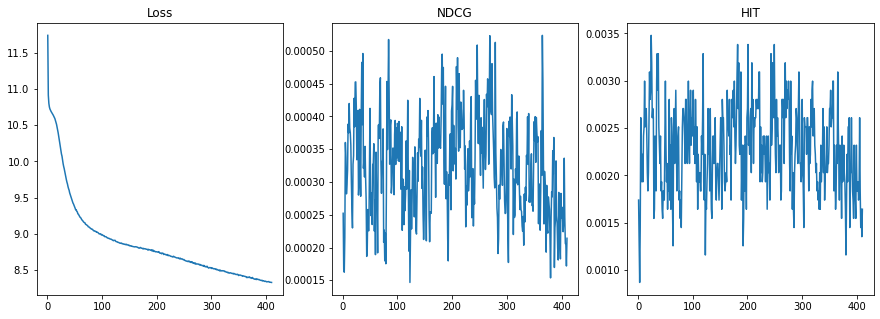

In [185]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, 411)]

ax[0].plot(epochs, loss_list)
ax[0].set_title('Loss')

ax[1].plot(epochs, ndcg_list)
ax[1].set_title('NDCG')

ax[2].plot(epochs, hit_list)
ax[2].set_title('HIT')
plt.show()
     